In [1]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Activation,Embedding,RepeatVector,TimeDistributed
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import time
from keras import metrics
from keras import optimizers
from keras import initializers
from keras.callbacks import ModelCheckpoint
import pprint
from keras.callbacks import Callback

from sklearn import metrics
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import Normalizer
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

Using TensorFlow backend.
c:\users\kahraman\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\kahraman\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\kahraman\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:
df = pd.read_csv('l_h_train_sm.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,1.0,3.0,40.0,0.0,0.000000,Aria
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria


In [3]:

X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data
X.shape

(8100, 300)

In [4]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [5]:
p=[]
for i in y:
    if i not in p:
        p.append(i)
        
for i,ii in enumerate (p)  :
    print(i,ii)
    

0 Aria
1 D-LinkCam
2 D-LinkDayCam
3 D-LinkDoorSensor
4 D-LinkHomeHub
5 D-LinkSensor
6 D-LinkSiren
7 D-LinkSwitch
8 D-LinkWaterSensor
9 EdimaxCam
10 EdimaxPlug1101W
11 EdimaxPlug2101W
12 EdnetCam
13 EdnetGateway
14 HomeMaticPlug
15 HueBridge
16 HueSwitch
17 IKettle2
18 Lightify
19 MAXGateway
20 SmarterCoffee
21 TP-LinkPlugHS100
22 TP-LinkPlugHS110
23 WeMoInsightSwitch
24 WeMoLink
25 WeMoSwitch
26 Withings


In [6]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)


In [7]:
p=[]
for i in y:

    if str(i)not in p:
        p.append(str(i))
        
for i,ii in enumerate (p)  :
    print(i,ii)
    

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26


In [8]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)

In [9]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [10]:
#Train test validation split - 60:20:20
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state=42)


In [11]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [12]:
# reshape input to be [samples, time steps, features]
Y_train = np.reshape(Y_train, (Y_train.shape[0],  Y_train.shape[1]))
Y_val = np.reshape(Y_val, (Y_val.shape[0],  Y_val.shape[1]))

In [13]:
# define LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(27, activation= "softmax" )))
#model.compile(loss= "categorical_crossentropy" , optimizer= "adam" , metrics=[ "accuracy" ])

#model.add(Dense(Y_train.shape[1], activation='softmax'))

nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                70200     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 27)             1377      
Total params: 91,777
Trainable params: 91,777
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
Y_train.shape

(6480, 27)

In [15]:
Y_train = np.reshape(Y_train, (Y_train.shape[0],1 , Y_train.shape[1]))
Y_val = np.reshape(Y_val, (Y_val.shape[0], 1, Y_val.shape[1]))

In [16]:

hdf5FileName = "long_mc_bestWeightsLSTMStateless3L50.hdf5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
checkpoint = ModelCheckpoint(hdf5FileName,monitor='val_acc',verbose=1,save_best_only=True,mode='max',save_weights_only=True)

In [17]:
#Time to train

start_time = time.time()



history=model.fit(X_train, Y_train, epochs=50, batch_size=10, verbose=2, shuffle=False,
            validation_data = (X_val,Y_val),callbacks=[checkpoint,es])  

print("--- %s seconds ---" % (time.time() - start_time))

from keras.models import load_model

model.save(hdf5FileName[:-3])  # creates a HDF5 file 'my_model.h5'



Train on 6480 samples, validate on 1620 samples
Epoch 1/50
 - 10s - loss: 1.6452 - acc: 0.5181 - val_loss: 0.8564 - val_acc: 0.7247

Epoch 00001: val_acc improved from -inf to 0.72469, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 2/50
 - 6s - loss: 0.6236 - acc: 0.7940 - val_loss: 0.5213 - val_acc: 0.8210

Epoch 00002: val_acc improved from 0.72469 to 0.82099, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 3/50
 - 5s - loss: 0.4226 - acc: 0.8420 - val_loss: 0.3870 - val_acc: 0.8531

Epoch 00003: val_acc improved from 0.82099 to 0.85309, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 4/50
 - 5s - loss: 0.3295 - acc: 0.8735 - val_loss: 0.3142 - val_acc: 0.8747

Epoch 00004: val_acc improved from 0.85309 to 0.87469, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 5/50
 - 5s - loss: 0.2757 - acc: 0.8881 - val_loss: 0.2683 - val_acc: 0.8870

Epoch 00005: val_acc improved from 0.87469 to 0.88704, saving model to long_mc_bes

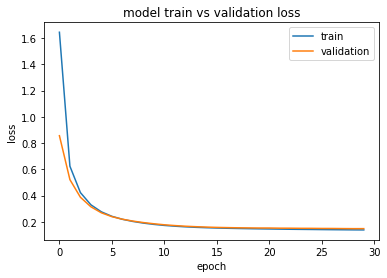

In [18]:


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import array
 

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')




pyplot.show()

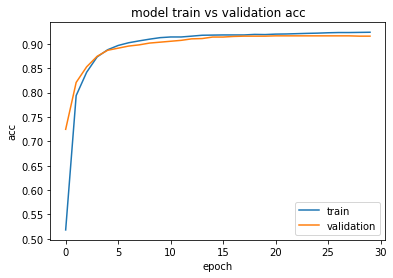

In [19]:

pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation acc')
pyplot.ylabel('acc')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()

## Test

In [20]:
df = pd.read_csv('l_h_test_sk.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,136.0,1.0,5.339931,Aria
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,1.0,64.0,1.0,3.772055,Aria


In [21]:
## 
X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data



from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)



from keras.utils import np_utils
y = np_utils.to_categorical(y)


# reshape input to be [samples, time steps, features]
X_test = np.reshape(X, (X.shape[0], 1, X.shape[1]))



# reshape input to be [samples, time steps, features]
Y_test = np.reshape(y, (y.shape[0],  y.shape[1]))


In [22]:
Y_test = np.reshape(y, (y.shape[0],  1,y.shape[1]))
Y_test

array([[[1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.]]])

## TEST DEĞERLENDİRME

In [23]:
loss,acc = model.evaluate(X_test,Y_test,batch_size=1)
print("Loss for testing = {} and Accuracy for testing = {}".format(loss,acc))
#predicted = model.predict(X_test)

1350/1350 [==============================] - 1s 756us/step
Loss for testing = 1.7037921176435207 and Accuracy for testing = 0.6851851851851852


In [24]:
predicted = model.predict(X_test,verbose=0)



In [25]:
predicted

array([[[3.4893774e-06, 1.0810554e-08, 2.1409401e-09, ...,
         2.2767426e-01, 1.6255143e-08, 1.2326989e-02]],

       [[9.9998522e-01, 4.0981114e-16, 2.2499661e-12, ...,
         7.7487448e-09, 1.4198948e-11, 1.4523392e-05]],

       [[9.9998522e-01, 4.0981114e-16, 2.2499661e-12, ...,
         7.7487448e-09, 1.4198948e-11, 1.4523392e-05]],

       ...,

       [[8.5487773e-06, 4.0785558e-13, 1.7023676e-11, ...,
         1.1673764e-09, 5.2317356e-10, 9.9993062e-01]],

       [[8.5497231e-06, 4.0787892e-13, 1.7024975e-11, ...,
         1.1674566e-09, 5.2322346e-10, 9.9993062e-01]],

       [[8.0657464e-06, 3.5972633e-13, 1.5037313e-11, ...,
         1.0389842e-09, 4.2124895e-10, 9.9994087e-01]]], dtype=float32)

In [26]:
(X_test.shape)

(1350, 1, 300)

In [27]:
#predicted = model.predict(X_test)

In [28]:
(predicted.shape)

(1350, 1, 27)

In [29]:
"""

for i in X_test:
    temp=i
    print(temp.shape) #(predicted)
    temp=(np.reshape(temp, (temp.shape[0], 1, temp.shape[1])))
    print(temp.shape) #(predicted)
    predicted = model.predict(temp,batch_size=1000)
    print(predicted)
    break
"""

'\n\nfor i in X_test:\n    temp=i\n    print(temp.shape) #(predicted)\n    temp=(np.reshape(temp, (temp.shape[0], 1, temp.shape[1])))\n    print(temp.shape) #(predicted)\n    predicted = model.predict(temp,batch_size=1000)\n    print(predicted)\n    break\n'

### grafik mırafik

In [30]:
def compute_metrics(predicted, Y_test):   
    Y_classes = [np.argmax(item) for item in Y_test]
    #print(Y_classes)
    predicted_classes = [np.argmax(item) for item in predicted]
    predictions = np.array(predicted_classes)
    Y_actual = np.array(Y_classes)
   
    y_actu = pd.Series(np.reshape(Y_actual,len(Y_actual)), name='Actual')
    y_pred = pd.Series(np.reshape(predictions, len(predictions)), name='Predicted')
    
    y_act = pd.Categorical(y_actu, categories=list(range(0,27)))
    y_pre = pd.Categorical(y_pred, categories=list(range(0,27)))
    
    #F1 score
    from sklearn.metrics import f1_score
    print("Average F1 score is {}".format(f1_score(Y_classes, predicted_classes, average='weighted', labels = list(range(0,27)))))
    
    df_confusion = pd.crosstab(y_act, y_pre, rownames =['Actual'],colnames=['Predicted'])
    print("Confusion matrix: \n", df_confusion)
    #pprint.pprint(df_confusion)
    return df_confusion
"""   
    predicted= np.array(predicted).tolist()
    Y_test = np.array(Y_test).tolist()

    n_classes = 27
    print("n_classes is: ", n_classes)
    Y_test= np.asarray(Y_test)
    predicted = np.asarray(predicted)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    lw = 2
    # Compute macro-average ROC curve and ROC area
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
    """ 

'   \n    predicted= np.array(predicted).tolist()\n    Y_test = np.array(Y_test).tolist()\n\n    n_classes = 27\n    print("n_classes is: ", n_classes)\n    Y_test= np.asarray(Y_test)\n    predicted = np.asarray(predicted)\n    \n    fpr = dict()\n    tpr = dict()\n    roc_auc = dict()\n    for i in range(n_classes):\n        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predicted[:, i])\n        roc_auc[i] = auc(fpr[i], tpr[i])\n\n    # Compute micro-average ROC curve and ROC area\n    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predicted.ravel())\n    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])\n    \n    lw = 2\n    # Compute macro-average ROC curve and ROC area\n    #First aggregate all false positive rates\n    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))\n\n    # Then interpolate all ROC curves at this points\n    mean_tpr = np.zeros_like(all_fpr)\n    for i in range(n_classes):\n        mean_tpr += interp(all_fpr, fpr[i], tpr[i])\n\n

In [31]:
predicted

array([[[3.4893774e-06, 1.0810554e-08, 2.1409401e-09, ...,
         2.2767426e-01, 1.6255143e-08, 1.2326989e-02]],

       [[9.9998522e-01, 4.0981114e-16, 2.2499661e-12, ...,
         7.7487448e-09, 1.4198948e-11, 1.4523392e-05]],

       [[9.9998522e-01, 4.0981114e-16, 2.2499661e-12, ...,
         7.7487448e-09, 1.4198948e-11, 1.4523392e-05]],

       ...,

       [[8.5487773e-06, 4.0785558e-13, 1.7023676e-11, ...,
         1.1673764e-09, 5.2317356e-10, 9.9993062e-01]],

       [[8.5497231e-06, 4.0787892e-13, 1.7024975e-11, ...,
         1.1674566e-09, 5.2322346e-10, 9.9993062e-01]],

       [[8.0657464e-06, 3.5972633e-13, 1.5037313e-11, ...,
         1.0389842e-09, 4.2124895e-10, 9.9994087e-01]]], dtype=float32)

In [32]:
print(predicted.shape, Y_test.shape)

(1350, 1, 27) (1350, 1, 27)


In [33]:
df_cm=compute_metrics(predicted, Y_test)

Average F1 score is 0.6857972081665343
Confusion matrix: 
 Predicted  0   1   2   3   4   5   6   7   8   9   ...  17  18  19  20  21  \
Actual                                             ...                       
0          41   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1           0  36   0   0   0   0   0   0   0  14  ...   0   0   0   0   0   
2           0   0  35   0   0   0   0   8   0   0  ...   0   0   0   0   0   
3           0   0   0  32   0   0   0   0   0   0  ...   0   0   0   0   0   
4           0   0   0   0  34  16   0   0   0   0  ...   0   0   0   0   0   
5           0   0   0   0   0  30  20   0   0   0  ...   0   0   0   0   0   
6           0   0   0   0   0   0  16   0  25   0  ...   0   0   0   0   0   
7           0   0   0   0   0   0  15  11   9   0  ...   0   0   0   0   0   
8           0   0   0   0   0   0  26   0  24   0  ...   0   0   0   0   0   
9           0   0   0   0   0   0  11   0   0  31  ...   0   8   0   0   0   
10   

In [34]:
matrix = df_cm.values

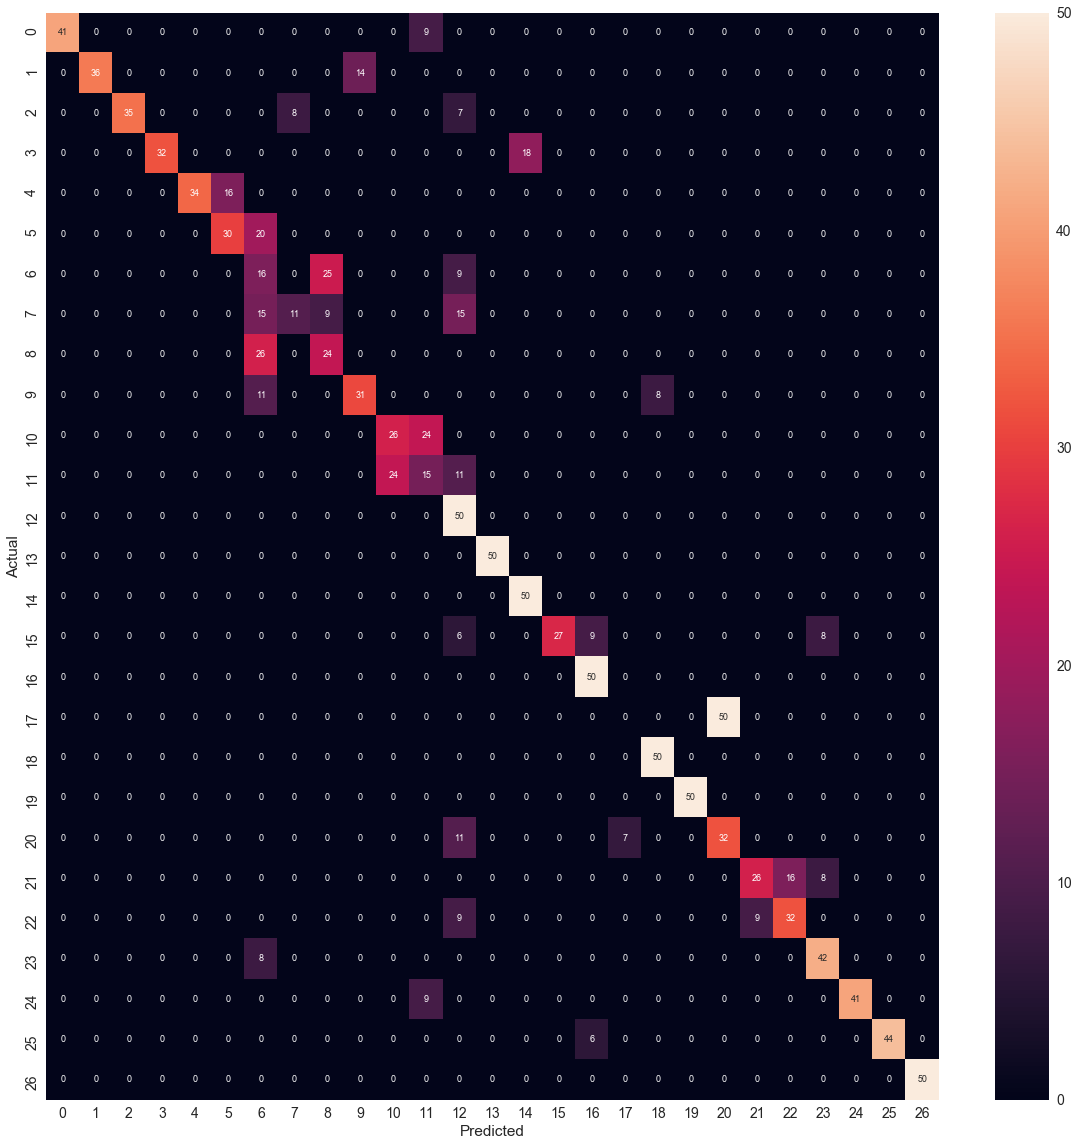

In [35]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt



#df_cm = pd.DataFrame(matrix, range(27), range(27))
plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

plt.show()

In [36]:
cm=matrix
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

print("label precision recall fscore")
for label in range(27):
    pr=precision(label, cm)
    rec=recall(label, cm)
    f1=2*(pr*rec/(pr+rec))
    print(f"{label:5d} {pr:9.3f} {rec:6.3f} {f1:6.3f}")

label precision recall fscore
    0     1.000  0.820  0.901
    1     1.000  0.720  0.837
    2     1.000  0.700  0.824
    3     1.000  0.640  0.780
    4     1.000  0.680  0.810
    5     0.652  0.600  0.625
    6     0.167  0.320  0.219
    7     0.579  0.220  0.319
    8     0.414  0.480  0.444
    9     0.689  0.620  0.653
   10     0.520  0.520  0.520
   11     0.263  0.300  0.280
   12     0.424  1.000  0.595
   13     1.000  1.000  1.000
   14     0.735  1.000  0.847
   15     1.000  0.540  0.701
   16     0.769  1.000  0.870
   17     0.000  0.000    nan
   18     0.862  1.000  0.926
   19     1.000  1.000  1.000
   20     0.390  0.640  0.485
   21     0.743  0.520  0.612
   22     0.667  0.640  0.653
   23     0.724  0.840  0.778
   24     1.000  0.820  0.901
   25     1.000  0.880  0.936
   26     1.000  1.000  1.000


c:\users\kahraman\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


## MODEL SAVING RELOADING

In [37]:
from keras.models import load_model

model.save('54.h5')  # creates a HDF5 file 'my_model.h5'



In [38]:

# returns a compiled model
# identical to the previous one
model = load_model('54.h5')